In [ ]:
# # install dependencies: (use cu101 because colab has CUDA 10.1)
# !pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
# !pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# import torch, torchvision
# print(torch.__version__, torch.cuda.is_available())
# !gcc --version
# # opencv is pre-installed on colab

In [175]:
# !pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
# !pip install google_colab

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from pathlib import Path
import os 
import pandas as pd 
import json 
import ast
from tqdm import tqdm
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [104]:
path = Path('/kaggle/input/global-wheat-detection')
os.listdir(path)

['sample_submission.csv', 'train.csv', 'test', 'train']

In [105]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [106]:
to_list = lambda x: ast.literal_eval(x)
df['bbox'] = df['bbox'].apply(to_list)

In [168]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [169]:
image_ids = df['image_id'].unique()[:100]
valid_ids = image_ids[75:]
train_ids = image_ids[:75]

In [170]:
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((697, 5), (2176, 5))

In [171]:
import pandas as pd
import json

def csv_to_coco(df, json_path):

    # Create a list of images and annotations
    images = []
    annotations = []
    categories = []
    category_id = 1

    # Iterate through the DataFrame and extract the relevant information
    for index, row in df.iterrows():
        image_id = row['image_id']
        file_name = f'{image_id}.jpg'
        width = row['width']
        height = row['height']
        x, y, w, h = row['bbox']

        # Add the image to the list of images
        images.append({
            'id': image_id,
            'file_name': file_name,
            'width': width,
            'height': height
        })

        # Add the annotation to the list of annotations
        annotations.append({
            'id': len(annotations) + 1,
            'image_id': image_id,
            'category_id': category_id,
            'bbox': [x, y, w, h],
            'iscrowd': 0,
            'area': w * h
        })

    # Add the category to the list of categories
    categories.append({
        'id': category_id,
        'name': 'wheat'
    })

    # Create the COCO dataset
    coco_data = {
        'info': {
            'description': 'Global Wheat Detection dataset',
            'version': '1.0',
            'year': 2020
        },
        'licenses': [],
        'images': images,
        'annotations': annotations,
        'categories': categories
    }

    # Write the COCO dataset to a JSON file
    with open(json_path, 'w') as f:
        json.dump(coco_data, f)

In [172]:
%%time 
csv_to_coco(train_df, 'train.json')

CPU times: user 189 ms, sys: 3.92 ms, total: 193 ms
Wall time: 193 ms


In [173]:
%%time 
csv_to_coco(valid_df, 'valid.json')

CPU times: user 68.2 ms, sys: 1.03 ms, total: 69.2 ms
Wall time: 68.4 ms


# Detectron

In [178]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train5", {}, "train.json", path/'train')
register_coco_instances("my_dataset_valid5", {}, "valid.json", path/'train')

[01/01 13:18:54 d2.data.datasets.coco]: Loaded 75 images in COCO format from train.json


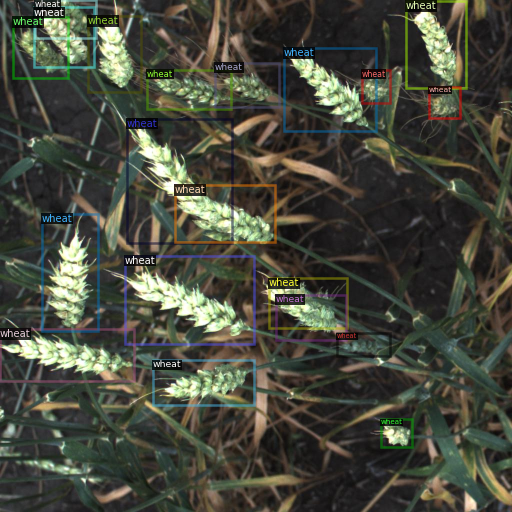

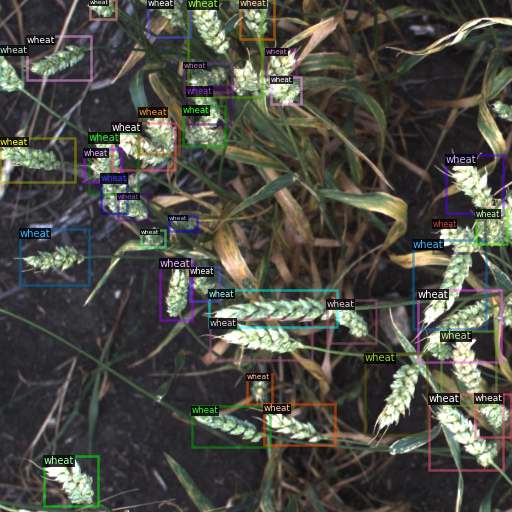

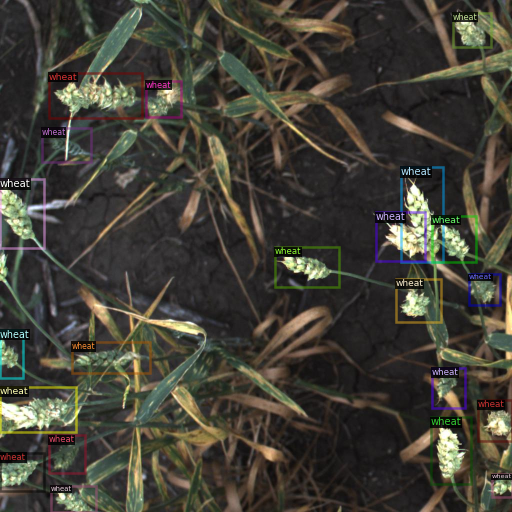

In [179]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train5")
dataset_dicts = DatasetCatalog.get("my_dataset_train5")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [180]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [181]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train4",)
cfg.DATASETS.TEST = ("my_dataset_valid4",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 100 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/01 13:18:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res